# Predicting Telco Churn
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

In [1]:
# import custom modules
from env import host, username, password
import acquire
import prepare

# data management imports
import numpy as np
import pandas as pd
import os

#import viz mmodules
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# modeling and preparation imports
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Project Planning
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

- Create a README.md with goals, data dictionary, and initial hypotheses 
- Acquire telco data from the Codeup database and create a function to automate the process
- Clean and prepare the data using a user defined function stored in the prepare.py module
- Clearly define two hypotheses and test them with statistical tests, document key findings and takeaways
- Establish baseline accuracy
- Train three different classification models
- Evaluate models on train and validate datasets
- Create a .csv with customer id, probability of target values, and the prediction. 
- Document conclusions, takeaways, and next steps

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

## Executive Summary
- Initial hypothesis is that users are less likely to churn if they are engaged with our services.
- Contract type, online security, tech support, and tenure are the strongest drivers of churn according to statistical testing
- I want to maximize recall while minimizing the false negative rates. 
- Between a DecisionTree, RandomForest, and KNeighbors algorithm, the KNeighbors model was the best with a recall score of 72% and a false negative rate of 28%. 
- Given more time, I would like to do some feature engineering such as scaling tenure to increase accuracy and recall

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Acquire Data

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

In [2]:
# read and cache telco data from codeup database
churn_db = acquire.get_telco_db('telco_churn')

In [3]:
# use function to get database information
prepare.get_info(churn_db)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


#### Acquire Takeaways
- I wrote a MySQL query that joins contract_type, internet_service_type, and payment_type into one dataframe for manipulation and wrangling. 
- inspection in SQL Ace shows that there are empty fields in the total_charges columns
- get_telco_db() function is used to import and cache the data as a .csv in the working directory
- the imported data has 7024 rows and 24 columns 
- Tenure has a different scale than either of the charges columns, and total_charges has a much larger range compared to  monthly_charges. 

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

## Prepare Data

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

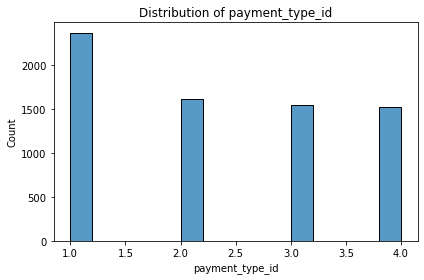

Counts for payment_type_id

1    2365
2    1612
3    1544
4    1522
Name: payment_type_id, dtype: int64



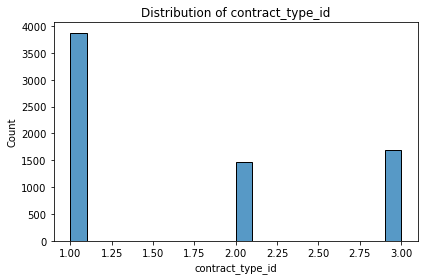

Counts for contract_type_id

1    3875
3    1695
2    1473
Name: contract_type_id, dtype: int64



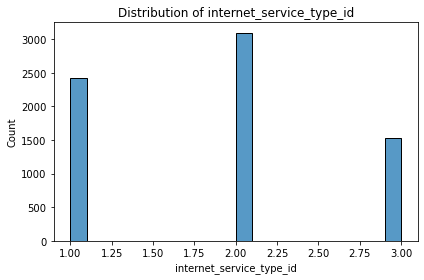

Counts for internet_service_type_id

2    3096
1    2421
3    1526
Name: internet_service_type_id, dtype: int64



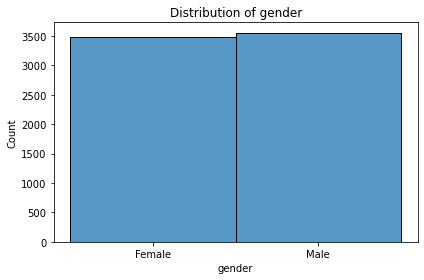

Counts for gender

Male      3555
Female    3488
Name: gender, dtype: int64



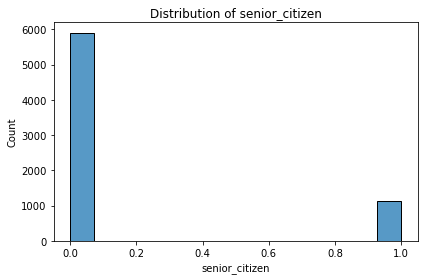

Counts for senior_citizen

0    5901
1    1142
Name: senior_citizen, dtype: int64



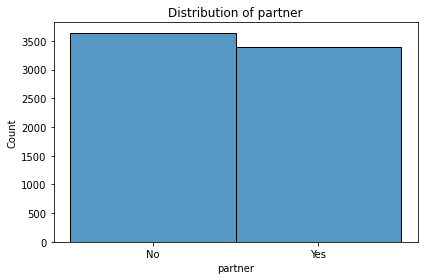

Counts for partner

No     3641
Yes    3402
Name: partner, dtype: int64



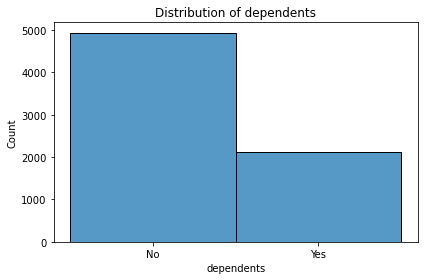

Counts for dependents

No     4933
Yes    2110
Name: dependents, dtype: int64



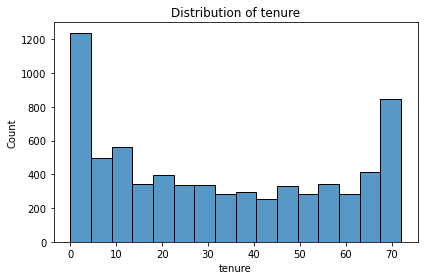

Counts for tenure

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64



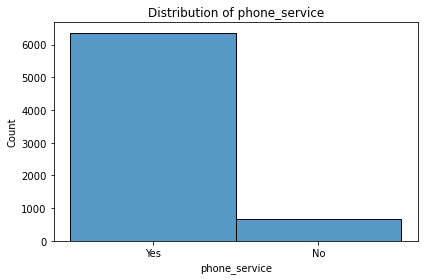

Counts for phone_service

Yes    6361
No      682
Name: phone_service, dtype: int64



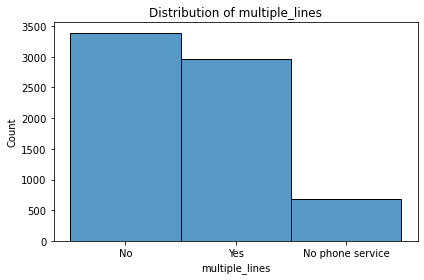

Counts for multiple_lines

No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64



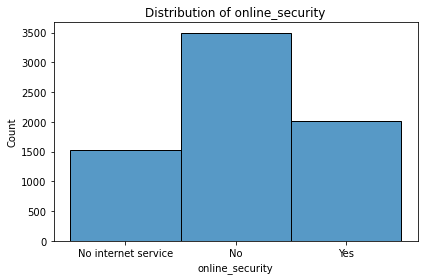

Counts for online_security

No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64



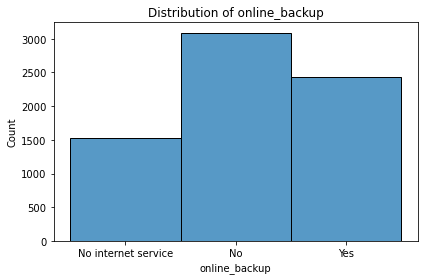

Counts for online_backup

No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64



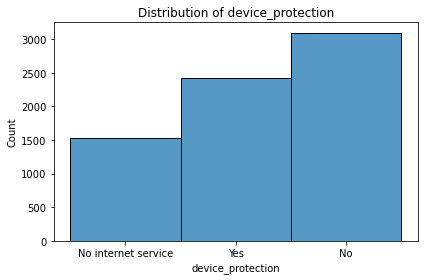

Counts for device_protection

No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64



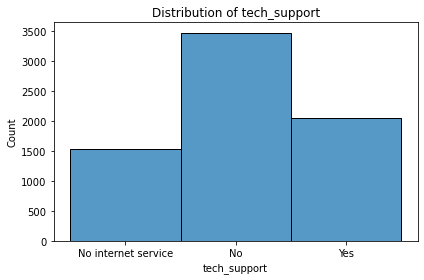

Counts for tech_support

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64



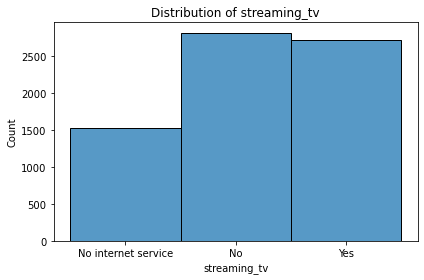

Counts for streaming_tv

No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64



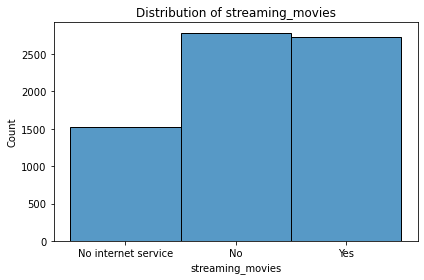

Counts for streaming_movies

No                     2785
Yes                    2732
No internet service    1526
Name: streaming_movies, dtype: int64



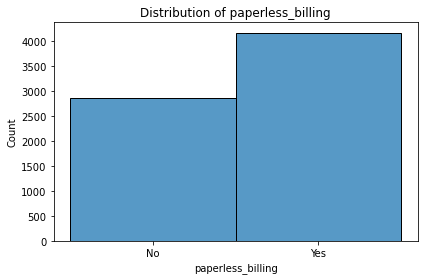

Counts for paperless_billing

Yes    4171
No     2872
Name: paperless_billing, dtype: int64



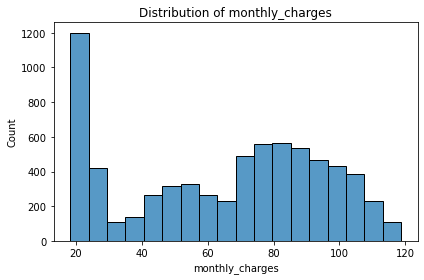

Counts for monthly_charges

20.05     61
19.85     45
19.90     44
19.95     44
19.65     43
          ..
107.20     1
112.35     1
23.15      1
86.95      1
23.40      1
Name: monthly_charges, Length: 1585, dtype: int64



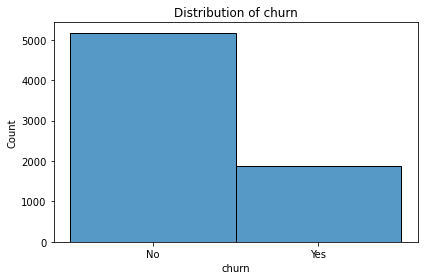

Counts for churn

No     5174
Yes    1869
Name: churn, dtype: int64



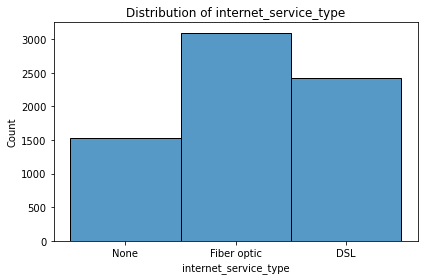

Counts for internet_service_type

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64



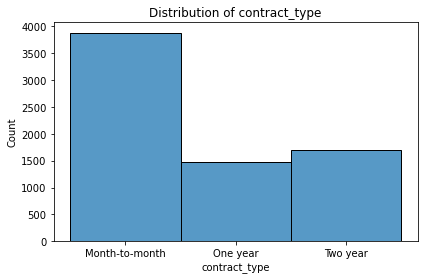

Counts for contract_type

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64



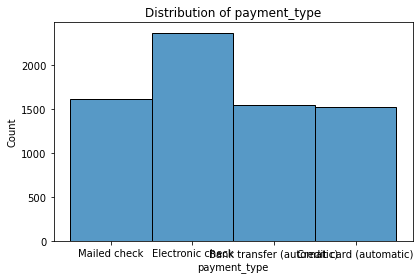

Counts for payment_type

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64



In [4]:
# for loop to show distributions of feature values
for x in churn_db.columns.drop(['customer_id', 'total_charges']):
    sns.histplot(churn_db[x])
    plt.title(f'Distribution of {x}')
    plt.tight_layout()
    plt.show()
    counts = churn_db[x].value_counts()
    print(f'Counts for {x}\n')
    print(f'{counts}\n') 

In [5]:
# use clean_churn to remove null values and convert total_charges to a float. Also drops customer_id column
churn_df = prepare.clean_churn(churn_db)

In [6]:
prepare.get_info(churn_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7043 non-null   object 
 1   senior_citizen         7043 non-null   int64  
 2   partner                7043 non-null   object 
 3   dependents             7043 non-null   object 
 4   tenure                 7043 non-null   int64  
 5   phone_service          7043 non-null   object 
 6   multiple_lines         7043 non-null   object 
 7   online_security        7043 non-null   object 
 8   online_backup          7043 non-null   object 
 9   device_protection      7043 non-null   object 
 10  tech_support           7043 non-null   object 
 11  streaming_tv           7043 non-null   object 
 12  streaming_movies       7043 non-null   object 
 13  paperless_billing      7043 non-null   object 
 14  monthly_charges        7043 non-null   float64
 15  tota

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,Female,0,No,No,3,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,19.85,57.20,No,None,Month-to-month,Mailed check
1,Female,0,Yes,Yes,4,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,Male,0,No,No,27,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.40,529.80,No,None,Month-to-month,Electronic check
3,Male,0,No,No,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,Female,0,Yes,No,10,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [7]:
# separate columns using churn as a target
train, validate, test = prepare.train_validate_test_split(churn_df, 'churn')

#### Prepare Takeaways
- There were 11 empty fields in monthly_charges that needed to be cleaned with the clean_churn() function
- Every column has 7043 fields, so there is no need to impute
- None of the continuous variables are normally distributed, must be analyzed with a non-parametric test
- customer_id, payment_type_id, contract_type_id, and internet_service_type_id were dropped due to redundancy 
- use train_validate_test_split() to split data

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Explore Data
<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

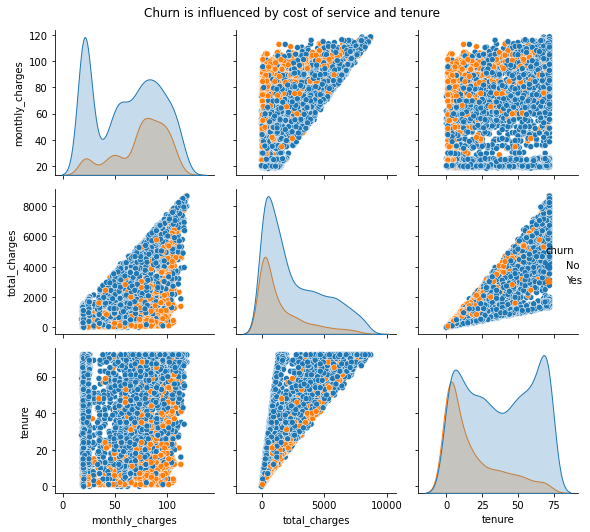

In [8]:
# Begin by visualizing continuous variables
sns.pairplot(train, vars = ['monthly_charges','total_charges','tenure'], hue = 'churn')
plt.suptitle('Churn is influenced by cost of service and tenure')
plt.tight_layout()
plt.show()

#### Pairplot takeaways
- the likelihood of a customer churning goes down the longer they are with the company
- high monthly charges seem to increase the likelihood of a customer churning

In [9]:
# encode values for heatmap
train = prepare.encode_values(train)
validate = prepare.encode_values(validate)
test = prepare.encode_values(test)
train.head()

/Users/parkervoit/Desktop/codeup-data-science/telco-classification-project/prepare.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x] = label_encoder.fit_transform(df[x])


,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
5707,1,1,1,0,72,1,2,1,1,1,1,1,1,1,85,2047,0,2,2,0
4471,0,0,1,1,56,1,0,0,0,0,0,2,2,0,903,3121,0,1,1,0
4994,1,1,0,0,60,1,2,2,2,0,0,0,2,1,611,2958,0,0,1,2
3458,0,1,1,0,25,1,2,2,0,0,2,2,0,1,571,2013,0,0,0,1
3818,1,0,0,0,20,1,2,2,0,0,2,0,0,0,431,1596,0,0,0,0


In [10]:
# visualize correlations of variables
heat = train[train.columns.drop(['gender','phone_service','multiple_lines', 'streaming_tv', 'streaming_movies','internet_service_type'])]

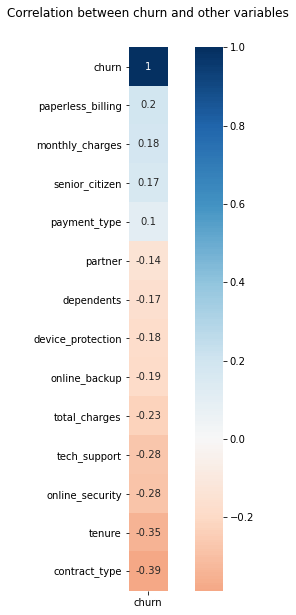

In [11]:
churn_heat = pd.DataFrame(heat.corr()['churn'])
plt.figure(figsize = [10,10])
sns.heatmap(churn_heat.sort_values(by = 'churn',ascending = False), center = 0, cmap='RdBu', annot=True, square = True)
plt.title('Correlation between churn and other variables', pad = 30)
plt.show()

#### Heatmap takeaways
- contract type, online security, tech support, tenure, and total_charges are most strongly correlated with churn. 
- positive values == more likely to churn
- negative values == less likely to churn

### Hypotheses and testing    
> I believe that the type of contract a user has and the amount of services they subscribe to influences whether or not they churn. I also believe that the longer a Telco customer remains loyal the less likely they will churn. 

#### Categorical testing

- **Hypothesis 1 -** Null rejected using chi2 test
- alpha = .05
- $H_0$: User churn is not correlated with the type of contracts they have. 
- $H_a$: User churn is correlated with the type of contract they have. 

- **Hypothesis 2 -** Null rejected using chi2 test
- alpha = .05
- $H_0$: User churn is not correlated with whether or not they have online security. 
- $H_a$: User churn is correlated with whether or not they have online security. 

- **Hypothesis 3 -** Null rejected using chi2 test
- alpha = .05
- $H_0$: User churn is not correlated with whether or not they have tech support. 
- $H_a$: User churn is correlated with whether or not they have tech support. 

In [12]:
# run a chi2 test on the three selected variables
for x in train[['contract_type','online_security','tech_support']]:
    cross = pd.crosstab(index = train['churn'], columns = train[x])
    chi, p, dof, expected = stats.chi2_contingency(cross)
    print(f'{x} values = chi : {chi}, p = {p}')

contract_type values = chi : 625.2957407588264, p = 1.6548365916266811e-136
online_security values = chi : 447.01229589460195, p = 8.560778789658601e-98
tech_support values = chi : 437.19716195898053, p = 1.1583572700703646e-95


#### Chi2 takeaways
- we can reject the null for all groups since all have a p > .05
- it suggests that user churn is correlated with the values, with contract_type having the strongest correlation
- they are all potential drivers

#### Continuous variable testing

- **Hypothesis 4 -** Null rejected using a Mann-Whitney U test
- alpha = .05
- $H_0$: The tenure of churned users is not different than users that do not churn. 
- $H_a$: The tenure of churned users have are different than users that don't churn.

In [13]:
# create two dataframes, one with churned users and one without
churned = train[train['churn'] == 1]
not_churned = train[train['churn'] == 0]

In [14]:
# test for normalcy to determine whether or not to use a parametric test
stats.normaltest(not_churned['tenure'])

NormaltestResult(statistic=27974.21330823005, pvalue=0.0)

- p value less than .05 implies that the data is significantly different than a bell curve, meaning tenure is not parametric.
- must use a non-parametric test when comparing means, Mann-Whitney's U would work.

In [29]:
# run a mann-whitney, alpha set at .05
stats.mannwhitneyu(churned['tenure'], not_churned['tenure'])

MannwhitneyuResult(statistic=797699.5, pvalue=8.060215373728185e-115)

#### Mann-Whitney takeaways
- we can reject the null that tenure is not different between churned and not-churned users
- it suggests that tenure is a driving factor 

### Explore Takeaways
- All four selected features are potentially useful for trying to predict user churn
- My first run through I will only use categorical variables so that I do not have to scale tenure
- If performance is lacking, tenure could be added but it would need to be scaled first

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Model and Evaluate

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

## Baseline accuracy
- uses the most common churn value (not churned = 0) to add a baseline column

In [30]:
# inputs baseline values and then calculates the accuracy compared to the actual churn rates
train['baseline'] = 0
baseline_accuracy = (train.baseline == train.churn).mean()
print(f'Baseline accuracy is {baseline_accuracy:.2%}')

Baseline accuracy is 73.47%


<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

## MVP models
- I will try out a DecisionTree, RandomForest, and KNeighbors classifier using the following features:
    - contract_type
    - tech_support
    - online_security
- Accuracy must be higher than 73% to be more effective than the baseline
- I want to choose the model that maximizes recall and minimizes false negative rates.
- I am using default parameters, with a random_state = 123 for the DecisionTree and RandomForest for reproducability
- I chose a n_neighbors value of 9 based off of a user function

In [17]:
# Define X_col and y_col, split into train, validate, and test columns
y_col = 'churn'
X_cols = ['contract_type','online_security','tech_support']
X_train, y_train = train[X_cols], train[y_col]
X_validate, y_validate = validate[X_cols], validate[y_col]
X_test, y_test = test[X_cols], test[y_col]

#### Decision Tree MVP

In [18]:
tree1 = DecisionTreeClassifier(random_state = 123)
tree1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [19]:
prepare.run_metrics(X_train, y_train, tree1, data_set = 'train')

train data set accuracy score: 76.21%
train data set precision score 54.52%
train data set recall score: 62.33%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2897
           1       0.55      0.62      0.58      1046

    accuracy                           0.76      3943
   macro avg       0.70      0.72      0.71      3943
weighted avg       0.77      0.76      0.77      3943

-------------------------------

confusion matrix
[[2353  544]
 [ 394  652]]

train data set model metrics
---------------------------------
True positive rate for the model is 62.33%
False positive rate for the model is  18.78%
True negative rate for the model is 81.22%
False negative rate for the model is 37.67%



In [20]:
prepare.run_metrics(X_validate, y_validate, tree1, 'validate')

validate data set accuracy score: 77.35%
validate data set precision score 56.20%
validate data set recall score: 66.59%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1242
           1       0.56      0.67      0.61       449

    accuracy                           0.77      1691
   macro avg       0.72      0.74      0.73      1691
weighted avg       0.79      0.77      0.78      1691

-------------------------------

confusion matrix
[[1009  233]
 [ 150  299]]

validate data set model metrics
---------------------------------
True positive rate for the model is 66.59%
False positive rate for the model is  18.76%
True negative rate for the model is 81.24%
False negative rate for the model is 33.41%



#### Random Forest MVP

In [21]:
rf1 = RandomForestClassifier(random_state = 123)
rf1.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [22]:
prepare.run_metrics(X_train, y_train, rf1, 'train')

train data set accuracy score: 76.21%
train data set precision score 54.52%
train data set recall score: 62.33%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      2897
           1       0.55      0.62      0.58      1046

    accuracy                           0.76      3943
   macro avg       0.70      0.72      0.71      3943
weighted avg       0.77      0.76      0.77      3943

-------------------------------

confusion matrix
[[2353  544]
 [ 394  652]]

train data set model metrics
---------------------------------
True positive rate for the model is 62.33%
False positive rate for the model is  18.78%
True negative rate for the model is 81.22%
False negative rate for the model is 37.67%



In [23]:
prepare.run_metrics(X_validate, y_validate, rf1, 'validate')

validate data set accuracy score: 77.35%
validate data set precision score 56.20%
validate data set recall score: 66.59%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1242
           1       0.56      0.67      0.61       449

    accuracy                           0.77      1691
   macro avg       0.72      0.74      0.73      1691
weighted avg       0.79      0.77      0.78      1691

-------------------------------

confusion matrix
[[1009  233]
 [ 150  299]]

validate data set model metrics
---------------------------------
True positive rate for the model is 66.59%
False positive rate for the model is  18.76%
True negative rate for the model is 81.24%
False negative rate for the model is 33.41%



#### KNeighbors MVP

In [33]:
# quick for loop to identify which n value has the c
for k in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    taccuracy = knn.score(X_test, y_test)
    vaccuracy = knn.score(X_validate, y_validate)
    print(f'{k:2d}: Test accuracy = {taccuracy:.2%}, Validate accuracy = {vaccuracy:.2%}')

 1: Test accuracy = 69.13%, Validate accuracy = 69.84%
 2: Test accuracy = 73.46%, Validate accuracy = 73.45%
 3: Test accuracy = 69.69%, Validate accuracy = 68.60%
 4: Test accuracy = 72.04%, Validate accuracy = 70.20%
 5: Test accuracy = 69.13%, Validate accuracy = 69.84%
 6: Test accuracy = 72.04%, Validate accuracy = 70.20%
 7: Test accuracy = 74.24%, Validate accuracy = 74.10%
 8: Test accuracy = 74.24%, Validate accuracy = 74.10%
 9: Test accuracy = 74.24%, Validate accuracy = 74.10%
10: Test accuracy = 73.46%, Validate accuracy = 73.45%
11: Test accuracy = 74.24%, Validate accuracy = 74.10%
12: Test accuracy = 73.46%, Validate accuracy = 73.45%
13: Test accuracy = 73.46%, Validate accuracy = 73.45%
14: Test accuracy = 73.46%, Validate accuracy = 73.45%
15: Test accuracy = 73.46%, Validate accuracy = 73.45%
16: Test accuracy = 73.46%, Validate accuracy = 73.45%
17: Test accuracy = 73.46%, Validate accuracy = 73.45%
18: Test accuracy = 73.46%, Validate accuracy = 73.45%
19: Test a

In [42]:
knn1 = KNeighborsClassifier(n_neighbors = 11)
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [43]:
prepare.run_metrics(X_train, y_train, knn1, 'train')

train data set accuracy score: 73.42%
train data set precision score 49.93%
train data set recall score: 71.41%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2897
           1       0.50      0.71      0.59      1046

    accuracy                           0.73      3943
   macro avg       0.69      0.73      0.70      3943
weighted avg       0.78      0.73      0.75      3943

-------------------------------

confusion matrix
[[2148  749]
 [ 299  747]]

train data set model metrics
---------------------------------
True positive rate for the model is 71.41%
False positive rate for the model is  25.85%
True negative rate for the model is 74.15%
False negative rate for the model is 28.59%



In [44]:
prepare.run_metrics(X_validate, y_validate, knn1, 'validate')

validate data set accuracy score: 74.10%
validate data set precision score 50.84%
validate data set recall score: 73.94%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1242
           1       0.51      0.74      0.60       449

    accuracy                           0.74      1691
   macro avg       0.70      0.74      0.71      1691
weighted avg       0.79      0.74      0.75      1691

-------------------------------

confusion matrix
[[921 321]
 [117 332]]

validate data set model metrics
---------------------------------
True positive rate for the model is 73.94%
False positive rate for the model is  25.85%
True negative rate for the model is 74.15%
False negative rate for the model is 26.06%



#### MVP Model - Takeaways
- My DecisionTree and RandomForest models predict churn at the same rate 
- All models are not overfit to the training data set
- Accuracy for the KNeighbors test model is the same as baseline, but I am more concerned with recall and false negative rates since those are the most costly conditions
- The other models are slighlty more accurate.
- I can use either DecisionTree or RandomForest, I will go with KNeighbors due to the metrics I am specifically looking at

## Testing
- best model is tree1

In [45]:
predicted_test = knn1.predict(X_test)
prepare.run_metrics(X_test, y_test, knn1, 'test')

test data set accuracy score: 74.24%
test data set precision score 51.04%
test data set recall score: 72.46%

-------------------------------
classification report
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.78      0.74      0.75      1409

-------------------------------

confusion matrix
[[775 260]
 [103 271]]

test data set model metrics
---------------------------------
True positive rate for the model is 72.46%
False positive rate for the model is  25.12%
True negative rate for the model is 74.88%
False negative rate for the model is 27.54%



<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Conclusions and Future Actions
- Churn is driven by how engaged a user is with telco services, cost of service, and tenure as a customer
- Using my KNeighbors, churn can be accurately predicted 74.24% of the time.
    - more importantly, it can accurately predict users who actually churn at a rate of 72.5% and only incorrectly identifies users as not churning 28%. 
    - It performs better than both the decision tree and the random forest in terms of recall and false negative rates, but it performs worse with identifying false positives and true negatives.
- Further work needs to be done on improving the overall accuracy of the model
    - Further feature engineering can be done with scaling monthly_costs and tenure so that they can be included in the model
    - Changing hyperparameters such as weights or metric to ensure a higher accuracy

<hr style="border-top: 10px groove green; margin-top: 1px; margin-bottom: 1px"></hr>

# Thank you for listening, any questions?